# Zero-Shot Video Classification with Feluda

This notebook demonstrates how to use the [`feluda`](https://github.com/tattle-made/feluda) package to extract video frames and classify the video using the [`zero-shot classification operator`](https://pypi.org/project/feluda-classify-video-zero-shot/) operator. It includes - 
- Setting up Feluda and its operators.
- Using video data from a subset of the [UCF101 video dataset](https://huggingface.co/datasets/sayakpaul/ucf101-subset) dataset. We are using this for demo, but can be replaced with any video dataset.
- Using Feluda's [`zero-shot classification operator`](https://pypi.org/project/feluda-classify-video-zero-shot/) to cluster vidoes.
- Visualizing the clusters with video thumbnails and the classified labels.

[![GitHub](https://img.shields.io/badge/GitHub-View%20Source-blue?logo=github)](https://github.com/tattle-made/feluda/blob/main/docs/examples/classify_video_zero_shot.ipynb)  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tattle-made/feluda/blob/main/docs/examples/classify_video_zero_shot.ipynb)

Install dependencies conditionally based on whether the notebook is running in Colab or locally.

In [ ]:
%%time
import os
import sys

IN_COLAB = "google.colab" in sys.modules
print("Running Notebook in Google Colab" if IN_COLAB else "Running Notebook locally")

if IN_COLAB:
    # Since Google Colab has preinstalled libraries like tensorflow and numba, we create a folder called feluda_custom_venv and isolate the environment there.
    # This is done to avoid any conflicts with the preinstalled libraries.
    %pip install uv
    !mkdir -p /content/feluda_custom_venv
    !uv pip install --target=/content/feluda_custom_venv --prerelease allow feluda feluda-classify-video-zero-shot opencv-python matplotlib > /dev/null 2>&1

    sys.path.insert(0, "/content/feluda_custom_venv")
else:
    !uv pip install feluda feluda-classify-video-zero-shot opencv-python matplotlib > /dev/null 2>&1

Running Notebook locally
Using Python 3.10.12 environment at: /home/aatman/Aatman/Tattle/feluda/.venv
Audited 6 packages in 11ms
CPU times: user 6.38 ms, sys: 4.13 ms, total: 10.5 ms
Wall time: 138 ms


In [1]:
import tarfile

import cv2
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download

from feluda.factory import VideoFactory


Dataset Structure Breakdown

- **UCF101_subset/**: The root directory containing the dataset.
  - **train/**: Contains training samples.
    - Each subdirectory under `train/` corresponds to a specific action class:
      - `BenchPress`
      - `BasketballDunk`
      - `BalanceBeam`
      - `ApplyLipstick`
      - `BabyCrawling`
      - `ApplyEyeMakeup`
      - `Archery`
      - `BandMarching`
      - `BaseballPitch`
      - `Basketball`
  - **test/**: Same as train.
  - **val/**: Same as train.

We'll take train subset as our example here.

In [ ]:
# Downloading and extracting

dataset_name = "UCF101_subset/train"
hf_dataset_identifier = "sayakpaul/ucf101-subset"
filename = "UCF101_subset.tar.gz"
file_path = hf_hub_download(
    repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"
)

with tarfile.open(file_path) as t:
    t.extractall(".")

/var/folders/4p/bw6h5x8x1nb_17vsgfc12dz00000gn/T/ipykernel_53804/3114774855.py:12: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  t.extractall(".")


Initializing Feluda operator for this example

In [ ]:
from feluda.operators import ClassifyVideoZeroShot

classifier = ClassifyVideoZeroShot()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
def get_video_thumbnail(video_path: str, save_path: str) -> str | None:
    """Extract and save the first frame from the video as a thumbnail."""
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()  # Read the first frame
    if ret:
        thumbnail_path = os.path.join(
            save_path, os.path.basename(video_path).replace(".avi", "_thumbnail.jpg")
        )
        cv2.imwrite(thumbnail_path, frame)  # Save the thumbnail as a JPEG
        cap.release()
        return thumbnail_path  # Return the path to the saved thumbnail
    cap.release()
    return None

In the below codeblock, we are predicting the class of video using classify_video_zero_shot operator. The operator uses CLIP-ViT-B-32 and a zero-shot approach.

In [ ]:

operator_parameter = []
labels = os.listdir(f"{dataset_name}")

for class_dir in labels:
    temp_list = os.listdir(os.path.join(dataset_name, class_dir))

    i = 0
    while i < len(temp_list) and i < 5:
        if temp_list[i] == "UCF101":
            i += 1
            continue

        video_full_path = os.path.join(dataset_name, class_dir, temp_list[i])

        # Extract and save the video thumbnail before processing
        thumbnail_save_dir = "thumbnails"
        os.makedirs(thumbnail_save_dir, exist_ok=True)
        thumbnail_path = get_video_thumbnail(video_full_path, thumbnail_save_dir)

        video_path = VideoFactory.make_from_file_on_disk(
            os.path.join(dataset_name, class_dir, temp_list[i])
        )

        operator_parameter.append(
            [
                classifier.run(video_path, labels),
                os.path.join(dataset_name, class_dir, temp_list[i]),
            ]
        )

        i += 1

`classify_video_zero_shot` operator output example that classifies video as `BenchPress`

In [7]:
operator_parameter[0][0]

{'prediction': 'BalanceBeam',
 'probs': [0.9969499707221985,
  4.102734601474367e-05,
  2.7282658265903592e-05,
  0.0002480082039255649,
  2.674547431524843e-05,
  3.819030462182127e-05,
  7.645731966476887e-05,
  0.00010040927008958533,
  0.002456656191498041,
  3.523077248246409e-05]}

Clustering videos  

This cell groups the videos by its predicted class

In [8]:
# preprocessing clusters for visualization

clusters = {key: [] for key in sorted(labels)}

for results in operator_parameter:
    class_predicted = results[0]["prediction"]
    payload_path = results[1]

    clusters[class_predicted].append(payload_path)

Visualizing Clusters

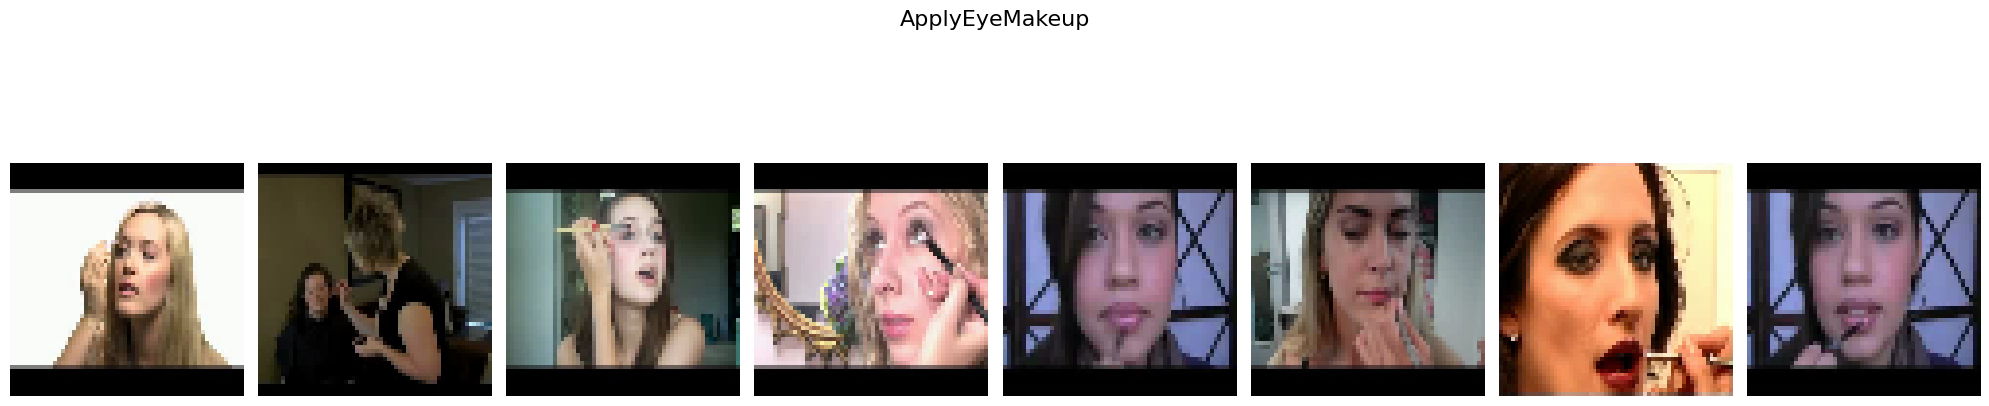

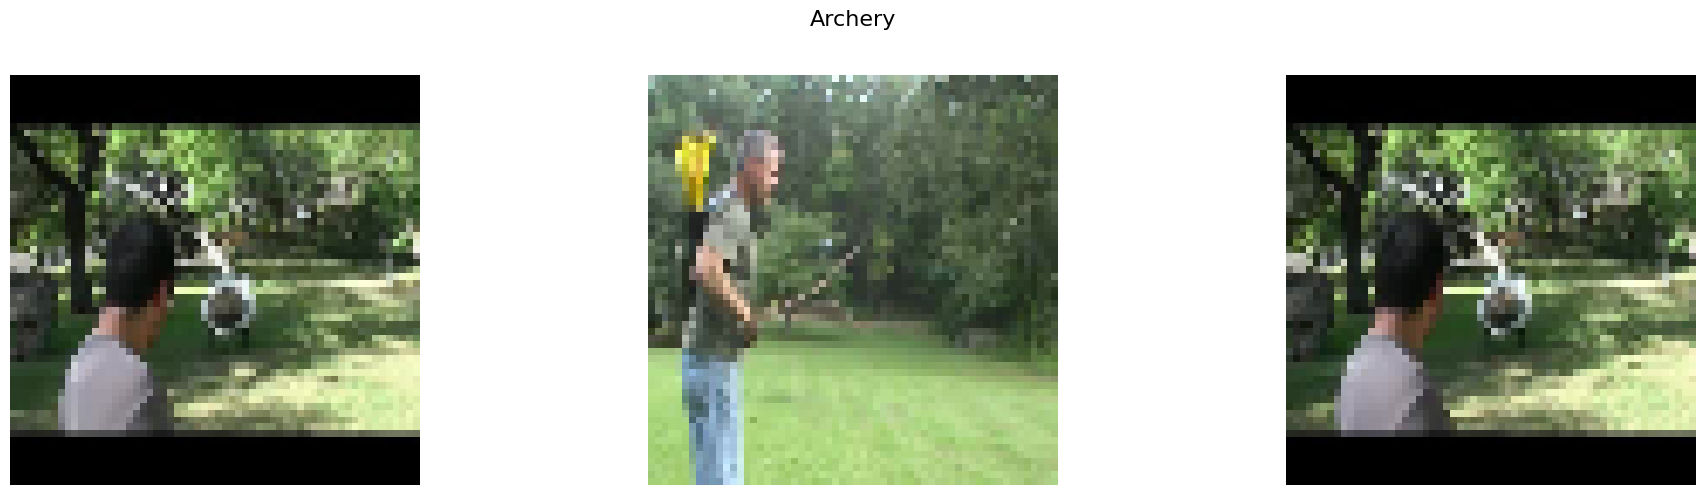

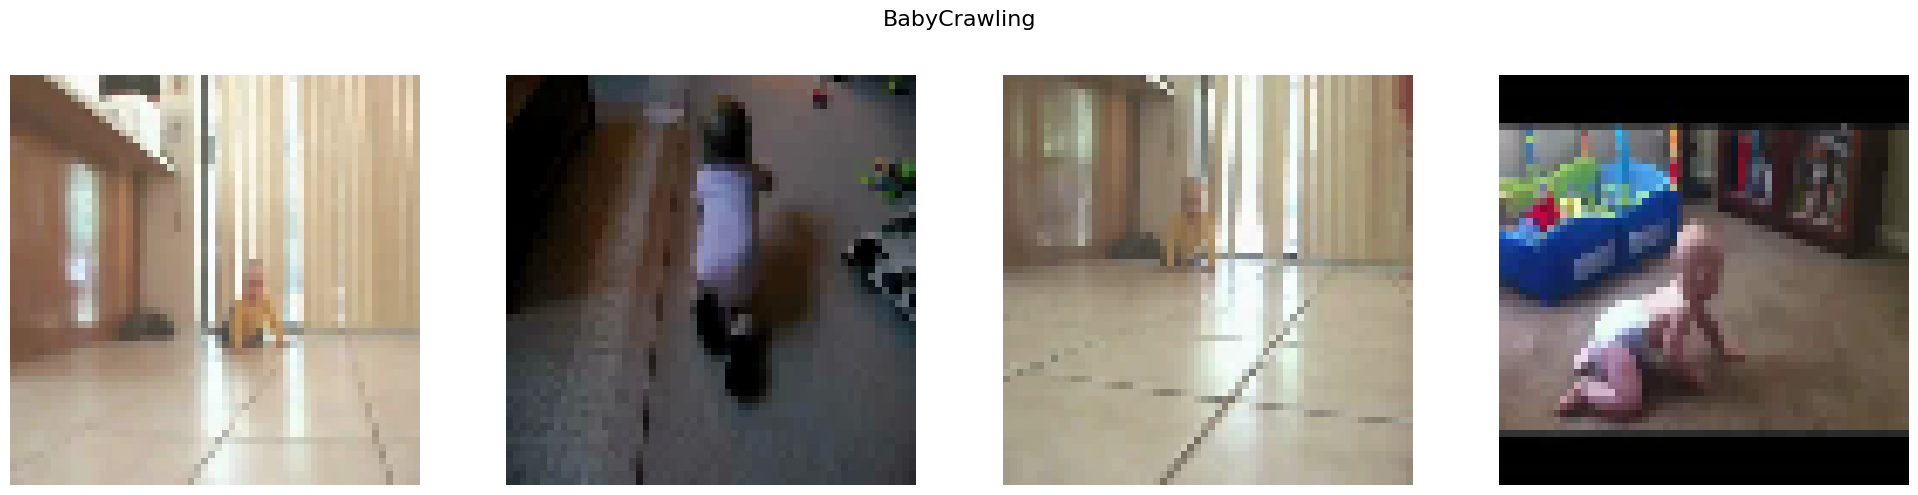

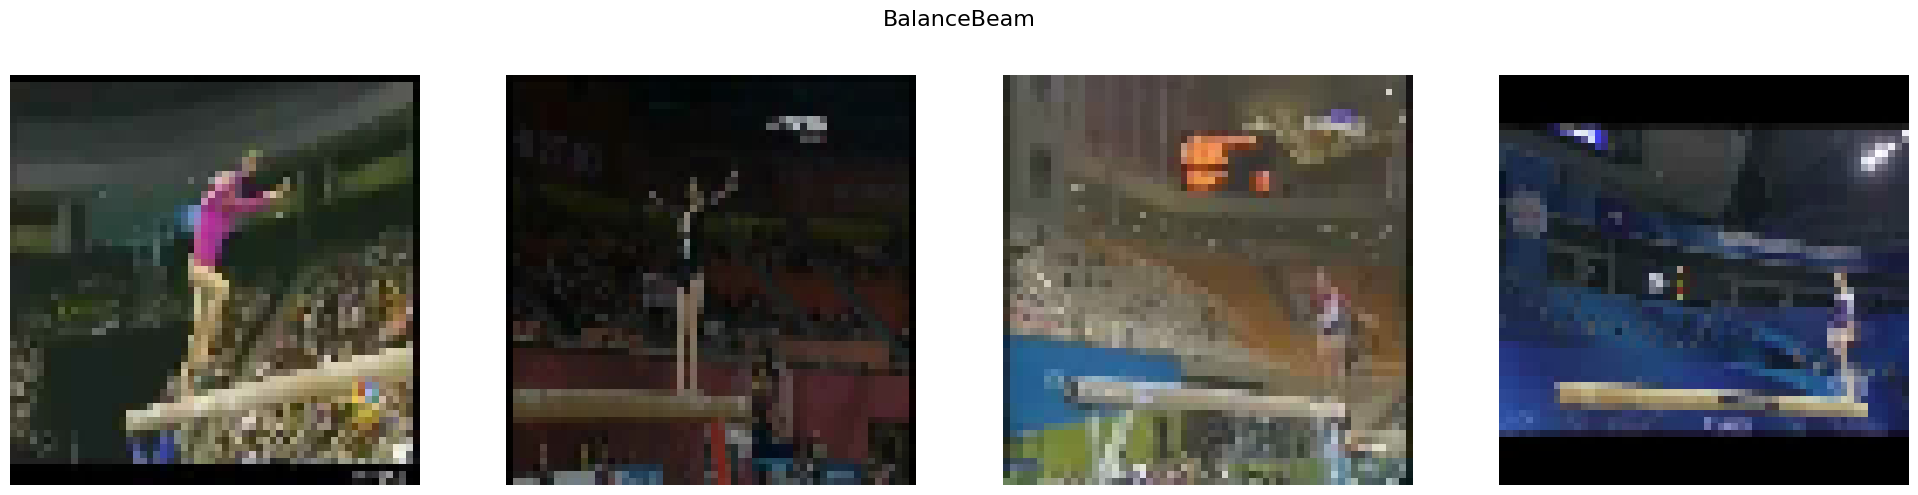

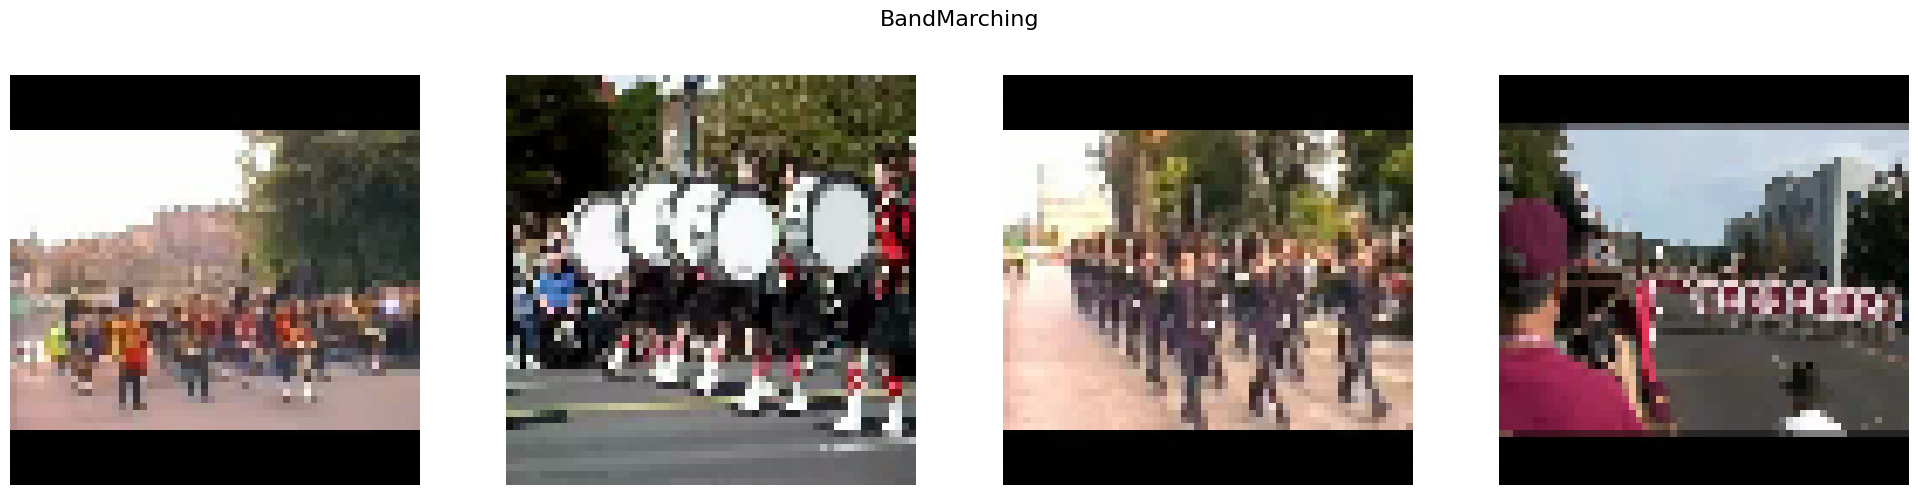

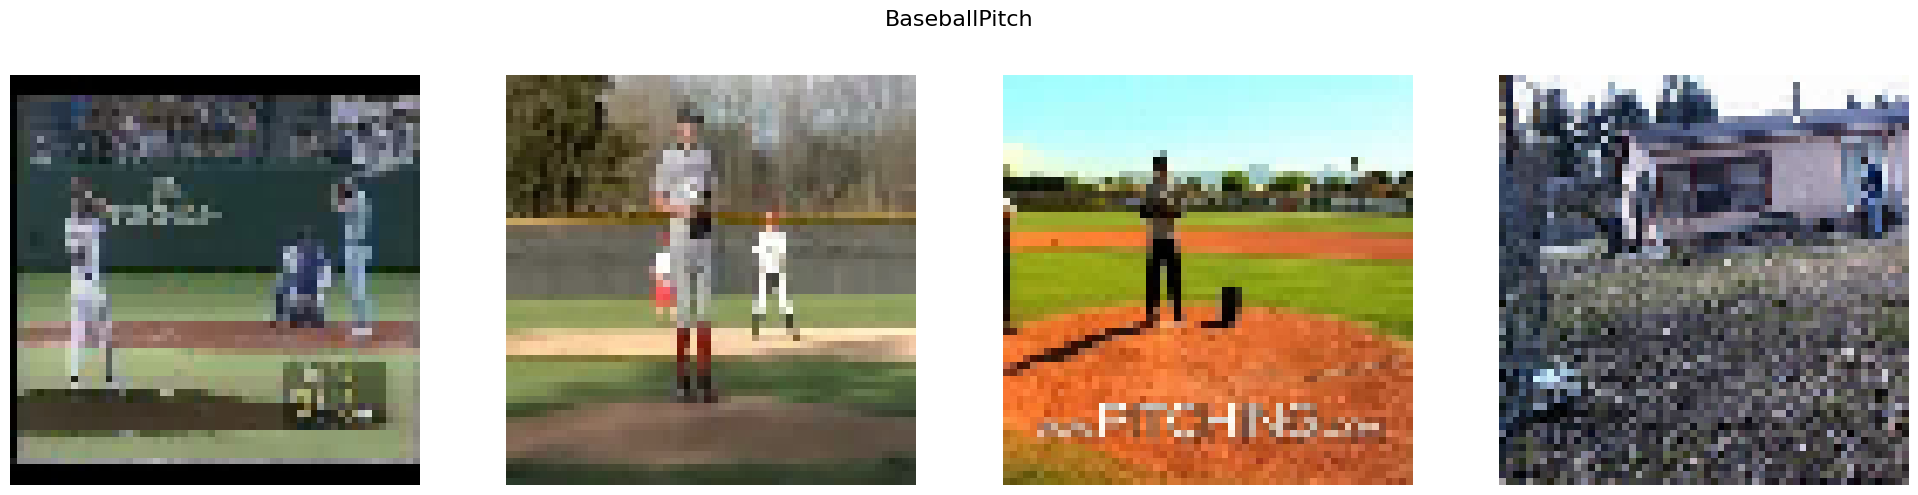

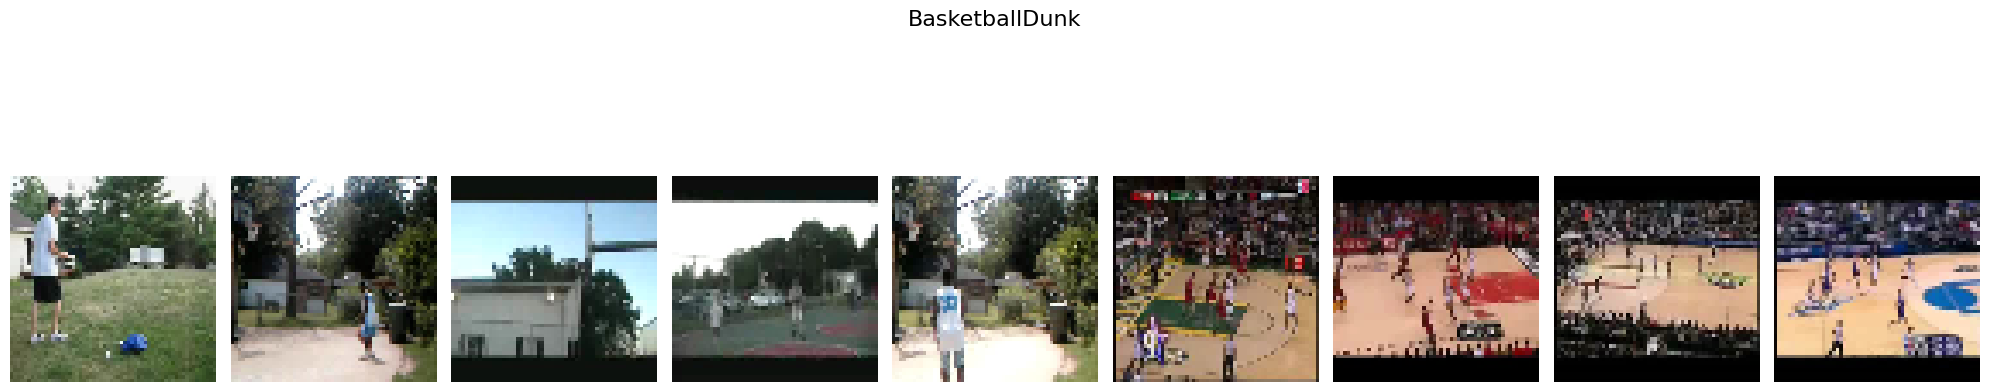

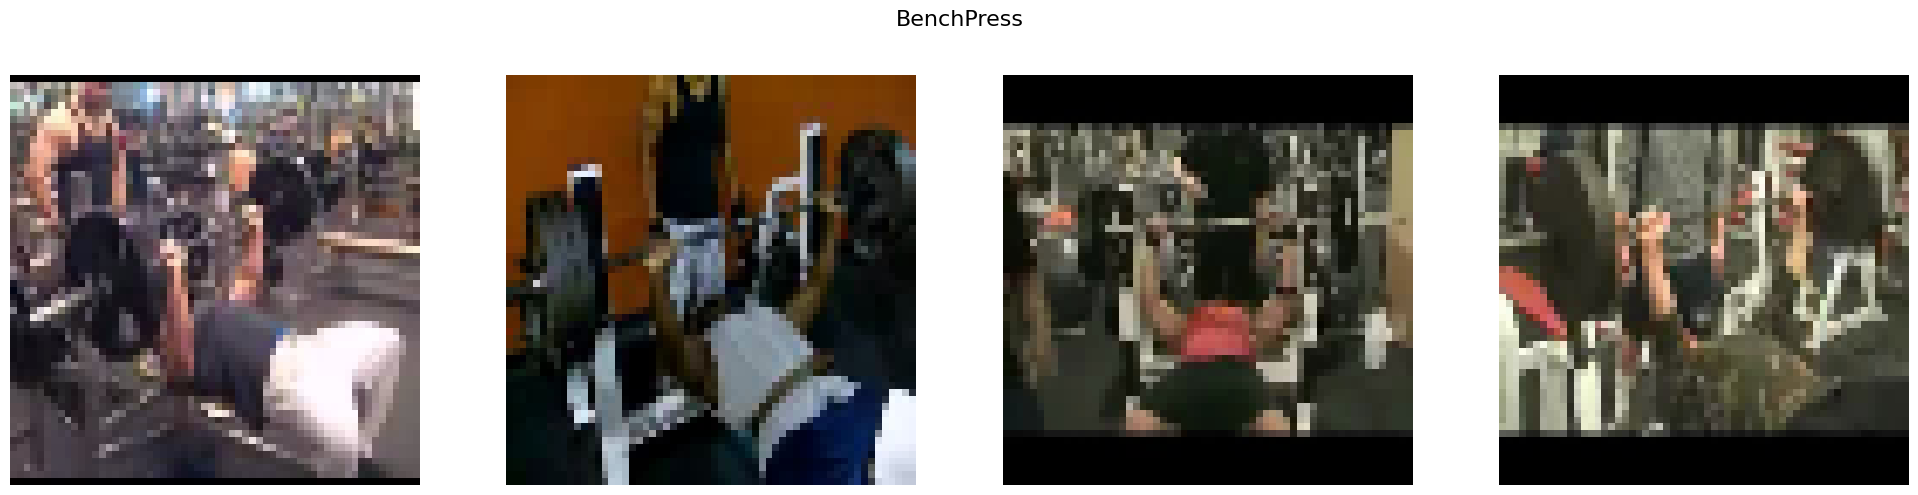

In [15]:
thumbnail_folder = "thumbnails"


def load_thumbnail(payload: str) -> str | None:
    """Load the thumbnail from the pre-saved thumbnail folder."""
    video_filename = os.path.basename(payload)
    thumbnail_filename = video_filename.replace(".avi", "_thumbnail.jpg")
    thumbnail_path = os.path.join(thumbnail_folder, thumbnail_filename)

    if os.path.exists(thumbnail_path):
        return cv2.imread(thumbnail_path)
    print(f"Thumbnail not found for {video_filename}")
    return None


for cluster_label, video_paths in clusters.items():
    num_videos = len(video_paths)
    if not num_videos:
        continue

    fig, axes = plt.subplots(1, num_videos, figsize=(20, 5))

    # Check if axes is a single Axes object or an array of Axes
    if num_videos == 1:
        axes = [axes]

    for i, video_path in enumerate(video_paths):
        video_thumbnail = load_thumbnail(video_path)
        if video_thumbnail is not None:
            video_thumbnail = cv2.cvtColor(
                cv2.resize(video_thumbnail, (60, 60)), cv2.COLOR_BGR2RGB
            )
            axes[i].imshow(video_thumbnail)
            axes[i].axis("off")

    plt.suptitle(f"{cluster_label}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

In [16]:
# Clean up resources when you're done
import shutil

shutil.rmtree("thumbnails")
shutil.rmtree("UCF101_subset")

classifier.cleanup()